### In this notebook we perform Centralized learning, almost like 02.Individual_Training. 

In centralized learning there is an entity that has access to data from all base stations.
Here, there is no option to filter out any base station.
In this setting we also measure the energy consumption using the Carbontracker tool.

In [1]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [2]:
import random

import numpy as np
import torch

from argparse import Namespace

In [3]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [4]:
from ml.utils.train_utils import train, test

In [5]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [6]:
args = Namespace(
    data_path='../dataset/full_dataset.csv', # dataset
    data_path_test=['../dataset/ElBorn_test.csv'], # test dataset
    test_size=0.2, # validation size 
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], # the target columns
    num_lags=10, # the number of past observations to feed as input

    
    filter_bs=None, # whether to use a single bs for training. It will be changed dynamically
    identifier='District', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=None, # whether to perform flooring and capping

    
    criterion='mse', # optimization criterion, mse or l1
    epochs=150, # the number of maximum epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    early_stopping=True, # whether to use early stopping
    patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.0, # l1 regularization
    reg2=0.0, # l2 regularization
    
    plot_history=True, # plot loss history

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

In [7]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(data_path='../dataset/full_dataset.csv', data_path_test=['../dataset/ElBorn_test.csv'], test_size=0.2, targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], num_lags=10, filter_bs=None, identifier='District', nan_constant=0, x_scaler='minmax', y_scaler='minmax', outlier_detection=None, criterion='mse', epochs=150, lr=0.001, optimizer='adam', batch_size=128, early_stopping=True, patience=50, max_grad_norm=0.0, reg1=0.0, reg2=0.0, plot_history=True, cuda=True, seed=0, assign_stats=None, use_time_features=False)



In [8]:
device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [9]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['rb_down', 'rb_up', 'down', 'up']
    outlier_kwargs = {"ElBorn": (10, 90), "LesCorts": (10, 90), "PobleSec": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [10]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [11]:
seed_all()

### By setting filter_bs to None, the preprocessing pipeline returns data from all three base stations

In [12]:
def make_preprocessing(filter_bs=None):
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path, filter_data=filter_bs)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets)
    
    # scale X
    X_train, X_val, x_scaler = scale_features(train_data=X_train, val_data=X_val,
                                             scaler=args.x_scaler, identifier=args.identifier)
    # scale y
    y_train, y_val, y_scaler = scale_features(train_data=y_train, val_data=y_val,
                                             scaler=args.y_scaler, identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None
        
    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler

In [13]:
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler = make_preprocessing()

INFO logger 2022-10-24 22:56:19,766 | data_utils.py:383 | Observations info in ElBorn
INFO logger 2022-10-24 22:56:19,766 | data_utils.py:384 | 	Total number of samples:  4192
INFO logger 2022-10-24 22:56:19,766 | data_utils.py:385 | 	Number of samples for training: 3354
INFO logger 2022-10-24 22:56:19,766 | data_utils.py:386 | 	Number of samples for validation:  838
INFO logger 2022-10-24 22:56:19,774 | data_utils.py:383 | Observations info in LesCorts
INFO logger 2022-10-24 22:56:19,774 | data_utils.py:384 | 	Total number of samples:  6892
INFO logger 2022-10-24 22:56:19,774 | data_utils.py:385 | 	Number of samples for training: 5514
INFO logger 2022-10-24 22:56:19,774 | data_utils.py:386 | 	Number of samples for validation:  1378
INFO logger 2022-10-24 22:56:19,782 | data_utils.py:383 | Observations info in PobleSec
INFO logger 2022-10-24 22:56:19,782 | data_utils.py:384 | 	Total number of samples:  15927
INFO logger 2022-10-24 22:56:19,782 | data_utils.py:385 | 	Number of samples f

In [14]:
X_train.head()

,rb_up_var_lag-10,rb_up_lag-10,rb_down_var_lag-10,rb_down_lag-10,mcs_up_var_lag-10,mcs_up_lag-10,mcs_down_var_lag-10,mcs_down_lag-10,rnti_count_lag-10,up_lag-10,...,rb_down_var_lag-1,rb_down_lag-1,mcs_up_var_lag-1,mcs_up_lag-1,mcs_down_var_lag-1,mcs_down_lag-1,rnti_count_lag-1,up_lag-1,down_lag-1,District
time,,,,,,,,,,,,,,,,,,,,,
2018-03-28 16:16:00,3.143298e-08,0.001213,4.497698e-08,0.040119,0.207425,0.483274,0.864261,0.937978,0.233939,0.001755,...,4.711435e-08,0.048765,0.232918,0.478785,0.862283,0.926591,0.281372,0.002074,0.091860,ElBorn
2018-03-28 16:18:00,4.439640e-08,0.001912,4.615535e-08,0.048621,0.259314,0.530084,0.864602,0.924797,0.279543,0.002709,...,4.562575e-08,0.048478,0.242482,0.499756,0.855495,0.931433,0.279886,0.002412,0.091507,ElBorn
2018-03-28 16:20:00,2.993595e-08,0.001362,4.646104e-08,0.044267,0.261772,0.512427,0.864957,0.930847,0.255049,0.001829,...,4.634120e-08,0.047619,0.241381,0.450879,0.867035,0.929728,0.274900,0.001903,0.089721,ElBorn
2018-03-28 16:22:00,5.382563e-08,0.002076,4.532153e-08,0.055921,0.320280,0.506925,0.854759,0.925932,0.321098,0.002827,...,4.689734e-08,0.056978,0.315197,0.495057,0.876713,0.927495,0.322424,0.003139,0.107071,ElBorn
2018-03-28 16:24:00,5.922178e-08,0.002290,4.655542e-08,0.060925,0.286799,0.497228,0.854279,0.929208,0.348702,0.003109,...,4.516392e-08,0.039556,0.267656,0.452835,0.861872,0.928728,0.232544,0.001653,0.075132,ElBorn


In [15]:
y_train.head()

,rnti_count,rb_down,rb_up,down,up,District
time,,,,,,
2018-03-28 16:16:00,0.279886,0.048478,0.001722,0.091507,0.002412,ElBorn
2018-03-28 16:18:00,0.274900,0.047619,0.001502,0.089721,0.001903,ElBorn
2018-03-28 16:20:00,0.322424,0.056978,0.002261,0.107071,0.003139,ElBorn
2018-03-28 16:22:00,0.232544,0.039556,0.001340,0.075132,0.001653,ElBorn
2018-03-28 16:24:00,0.313391,0.054345,0.001927,0.102806,0.002580,ElBorn


In [16]:
x_scaler, y_scaler

(MinMaxScaler(), MinMaxScaler())

In [17]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    # centralized (all) learning specific
    if not args.filter_bs and exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [18]:
X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler)

In [19]:
area_X_train.keys()

dict_keys(['ElBorn', 'LesCorts', 'PobleSec'])

In [20]:
area_X_val.keys()

dict_keys(['ElBorn', 'LesCorts', 'PobleSec'])

In [21]:
X_train[:2]

array([[[[3.14329753e-08],
         [1.21277163e-03],
         [4.49769750e-08],
         [4.01188992e-02],
         [2.07425252e-01],
         [4.83274072e-01],
         [8.64260554e-01],
         [9.37977910e-01],
         [2.33939394e-01],
         [1.75528484e-03],
         [7.64968917e-02]],

        [[4.43963977e-08],
         [1.91187230e-03],
         [4.61553498e-08],
         [4.86211926e-02],
         [2.59314001e-01],
         [5.30084312e-01],
         [8.64602447e-01],
         [9.24797297e-01],
         [2.79542595e-01],
         [2.70937034e-03],
         [9.14471596e-02]],

        [[2.99359542e-08],
         [1.36231177e-03],
         [4.64610359e-08],
         [4.42666970e-02],
         [2.61771828e-01],
         [5.12427032e-01],
         [8.64957333e-01],
         [9.30847228e-01],
         [2.55048603e-01],
         [1.82946306e-03],
         [8.37529153e-02]],

        [[5.38256302e-08],
         [2.07580579e-03],
         [4.53215314e-08],
         [5.59207276e-

In [22]:
y_train[:2]

array([[0.27988565, 0.04847769, 0.00172214, 0.09150688, 0.00241223],
       [0.27489996, 0.04761904, 0.00150213, 0.08972067, 0.00190256]],
      dtype=float32)

In [23]:
len(X_train), len(X_val)

(21580, 5371)

In [24]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [25]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [26]:
# define the model
args.model_name = "gru"

input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

print(input_dim, exogenous_dim)

model = get_model(model=args.model_name,
                  input_dim=input_dim,
                  out_dim=y_train.shape[1],
                  lags=args.num_lags,
                  exogenous_dim=exogenous_dim,
                  seed=args.seed)

11 0


In [27]:
model

GRU(
  (gru): GRU(11, 128, batch_first=True)
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [28]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=[8, 3, 1, 10, 9], # the indices of our targets in X
        log_per=1):
    
    # get exogenous data (if any)
    if exogenous_data_train is not None and len(exogenous_data_train) > 1:
        exogenous_data_train = exogenous_data_train["all"]
        exogenous_data_val = exogenous_data_val["all"]
    elif exogenous_data_train is not None and len(exogenous_data_train) == 1:
        cid = next(iter(exogenous_data_train.keys()))
        exogenous_data_train = exogenous_data_train[cid]
        exogenous_data_val = exogenous_data_val[cid]
    else:
        exogenous_data_train = None
        exogenous_data_val = None
    num_features = len(X_train[0][0])
    
    # to torch loader
    train_loader = to_torch_dataset(X_train, y_train,
                                    num_lags=args.num_lags,
                                    num_features=num_features,
                                    exogenous_data=exogenous_data_train,
                                    indices=idxs,
                                    batch_size=args.batch_size, 
                                    shuffle=False)
    val_loader = to_torch_dataset(X_val, y_val, 
                                  num_lags=args.num_lags,
                                  num_features=num_features,
                                  exogenous_data=exogenous_data_val,
                                  indices=idxs,
                                  batch_size=args.batch_size,
                                  shuffle=False)
    
    # train the model
    model = train(model, 
                  train_loader, val_loader,
                  epochs=args.epochs,
                  optimizer=args.optimizer, lr=args.lr,
                  criterion=args.criterion,
                  early_stopping=args.early_stopping,
                  patience=args.patience,
                  plot_history=args.plot_history, 
                  device=device, log_per=log_per,
                  use_carbontracker=True)
    
    return model

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX 1650 Ti.


INFO logger 2022-10-24 22:56:35,981 | train_utils.py:97 | Epoch 1 [Train]: loss 0.003362360383613316, mse: 0.0014821417862549424, rmse: 0.038498594601036315, mae 0.01988358423113823, r2: 0.6481391199712613, nrmse: 1.211988530862326
INFO logger 2022-10-24 22:56:35,981 | train_utils.py:99 | Epoch 1 [Test]: loss 5.0885799606463344e-06, mse: 0.0006503971526399255, rmse: 0.025502885182659734, mae 0.015069444663822651, r2: 0.5788994666257106, nrmse: 1.4976602246208361
INFO logger 2022-10-24 22:56:35,989 | helpers.py:148 | Validation loss decreased (inf --> 0.000005). Caching model ...


CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:00:11
	Energy:	0.000027 kWh
	CO2eq:	0.007892 g
	This is equivalent to:
	0.000066 km travelled by car
CarbonTracker: 
Predicted consumption for 150 epoch(s):
	Time:	0:28:29
	Energy:	0.004024 kWh
	CO2eq:	1.183827 g
	This is equivalent to:
	0.009832 km travelled by car
CarbonTracker: Finished monitoring.


INFO logger 2022-10-24 22:56:39,532 | train_utils.py:97 | Epoch 2 [Train]: loss 0.0013997200853656288, mse: 0.0011750881094485521, rmse: 0.034279558186309116, mae 0.016529232263565063, r2: 0.7188824393802479, nrmse: 1.1056780835392557
INFO logger 2022-10-24 22:56:39,540 | train_utils.py:99 | Epoch 2 [Test]: loss 4.326711965229253e-06, mse: 0.000552975689060986, rmse: 0.02351543512378595, mae 0.012636438012123108, r2: 0.6438951342489813, nrmse: 1.370843508901875
INFO logger 2022-10-24 22:56:39,540 | helpers.py:148 | Validation loss decreased (0.000005 --> 0.000004). Caching model ...
INFO logger 2022-10-24 22:56:42,078 | train_utils.py:97 | Epoch 3 [Train]: loss 0.0011278649705710833, mse: 0.0010529655264690518, rmse: 0.032449430294984406, mae 0.015142296440899372, r2: 0.7451748609607612, nrmse: 1.0766963792972208
INFO logger 2022-10-24 22:56:42,078 | train_utils.py:99 | Epoch 3 [Test]: loss 4.10277706639329e-06, mse: 0.000524334900546819, rmse: 0.022898360215238535, mae 0.0118557596579

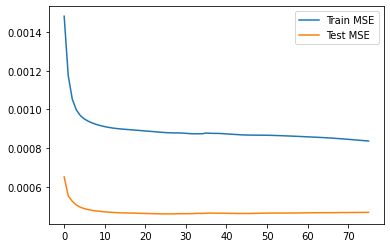

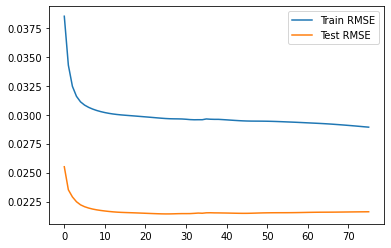

INFO logger 2022-10-24 22:58:51,072 | train_utils.py:140 | Best Loss: 3.5939461374057576e-06, Best epoch: 76


In [29]:
trained_model = fit(model, X_train, y_train, X_val, y_val)